In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. CONFIGURACIÓN DE RUTAS Y PARÁMETROS
DATASET_PATH = '/content/drive/MyDrive/Dataset' # <-- Pon aquí la ruta a la carpeta que contiene las subcarpetas
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 2. CARGA Y DIVISIÓN AUTOMÁTICA (80% Train / 20% Validation)
# Esto soluciona tu problema de no tener los datos separados
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical' # Importante para clasificación multiclase
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"Clases detectadas ({len(class_names)}): {class_names}")
# Debería imprimir: ['Geranio', 'Hierbabuena', ..., 'valeriana']

# 3. OPTIMIZACIÓN DE RENDIMIENTO (Cache y Prefetch)
# Esto hace que el entrenamiento sea mucho más rápido cargando imágenes en memoria
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1886 files belonging to 12 classes.
Using 1509 files for training.
Found 1886 files belonging to 12 classes.
Using 377 files for validation.
Clases detectadas (12): ['Geranio', 'HierbaLuisa', 'Hierbabuena', 'Jazmin', 'Limon', 'Nooni', 'Ruda', 'Sabila', 'ketoketo', 'retama', 'romero', 'valeriana']


In [ ]:
def construir_modelo_plantas(num_classes):

    inputs = tf.keras.Input(shape=(224, 224, 3))

    # --- A. DATA AUGMENTATION (Solo activo durante el entrenamiento) ---
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)

    # --- B. PREPROCESAMIENTO ESPECÍFICO MOBILENET ---
    # MobileNetV2 espera pixeles entre [-1, 1], no [0, 255]
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    # --- C. BASE PRE-ENTRENADA (Tu código) ---
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False # Congelamos los pesos base

    x = base_model(x, training=False)

    # --- D. CABECERA (HEAD) PERSONALIZADA ---
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x) # Reduce el overfitting

    # Capa de salida con 'softmax' para multiclase
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Instanciar el modelo
model = construir_modelo_plantas(len(class_names))

# Compilar
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Entrenamos la "cabeza" del modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15 # Empieza con 10, si mejora, sube a 20
)



Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.3566 - loss: 2.0203 - val_accuracy: 0.7745 - val_loss: 0.7315
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8027 - loss: 0.6509 - val_accuracy: 0.8541 - val_loss: 0.5268
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8683 - loss: 0.4323 - val_accuracy: 0.8859 - val_loss: 0.4143
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8984 - loss: 0.3356 - val_accuracy: 0.8912 - val_loss: 0.3825
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9280 - loss: 0.2678 - val_accuracy: 0.9019 - val_loss: 0.3345
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9140 - loss: 0.2824 - val_accuracy: 0.9098 - val_loss: 0.3270
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9495 - loss: 0.2083 - val_accuracy: 0.9019 - val_loss: 0.3086
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9561 - loss: 0.1878 - val_accuracy: 0.9045 - val_l

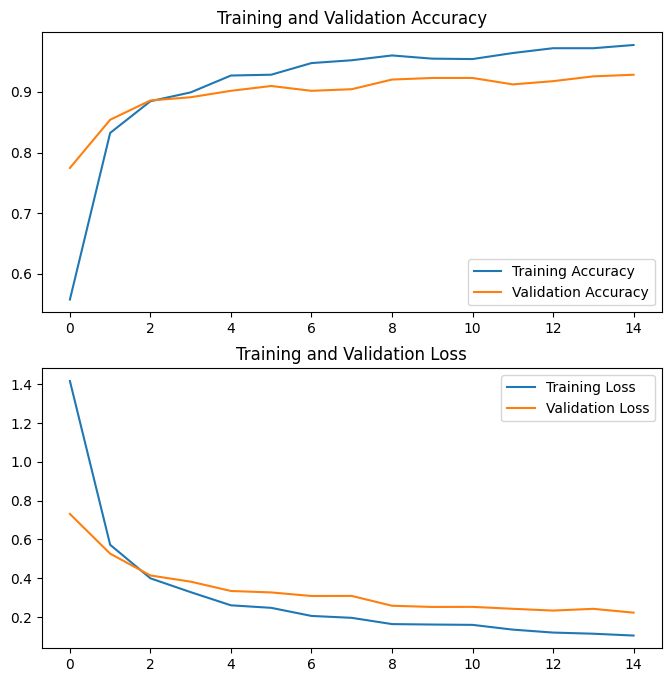

In [ ]:
# Visualización rápida de resultados
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Generando predicciones... (esto puede tardar un momento)


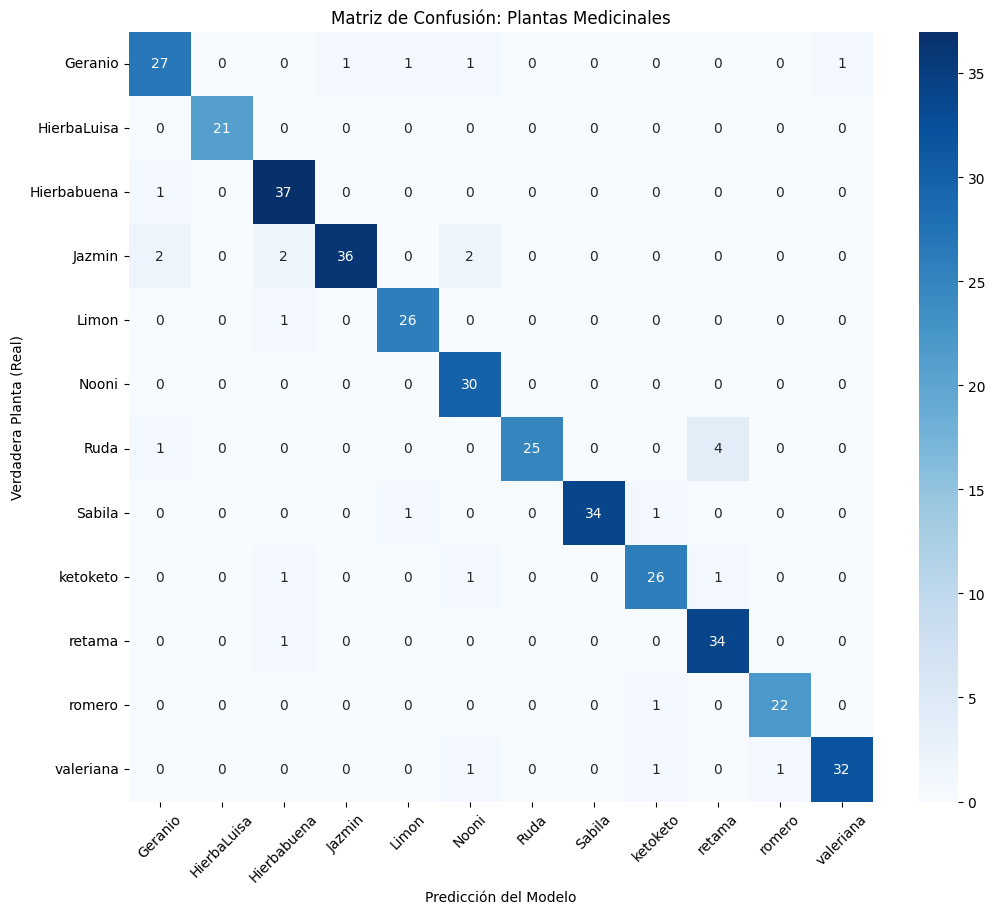

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def graficar_matriz_confusion(dataset, modelo):
    print("Generando predicciones... (esto puede tardar un momento)")

    all_labels = []
    all_preds = []

    # 1. Extraemos las imágenes y etiquetas del dataset de validación
    for images, labels in dataset:
        # Predecimos el batch actual
        preds = modelo.predict(images, verbose=0)

        # Convertimos las probabilidades a la clase ganadora (índice numérico)
        # axis=1 busca el valor más alto en la fila
        all_preds.extend(np.argmax(preds, axis=1))

        # Convertimos las etiquetas reales (one-hot) a índice numérico
        all_labels.extend(np.argmax(labels.numpy(), axis=1))

    # 2. Calculamos la matriz con scikit-learn
    cm = confusion_matrix(all_labels, all_preds)

    # 3. Graficamos con Seaborn (Heatmap)
    plt.figure(figsize=(12, 10)) # Tamaño grande para que quepan los 12 nombres
    sns.heatmap(cm,
                annot=True,       # Mostrar números dentro de los cuadros
                fmt='d',          # Formato entero (sin decimales)
                cmap='Blues',     # Color azul profesional
                xticklabels=class_names, # Nombres de tus plantas en el eje X
                yticklabels=class_names) # Nombres de tus plantas en el eje Y

    plt.ylabel('Verdadera Planta (Real)')
    plt.xlabel('Predicción del Modelo')
    plt.title('Matriz de Confusión: Plantas Medicinales')
    plt.xticks(rotation=45) # Rotar nombres para leerlos bien
    plt.show()

# --- EJECUTAR ---
graficar_matriz_confusion(val_ds, model)

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import cv2

def categorizar(url):
    # 1. Obtener imagen de la web
    respuesta = requests.get(url)
    img = Image.open(BytesIO(respuesta.content))

    # 2. Asegurar que sea RGB (3 canales)
    img = img.convert('RGB')

    # 3. Convertir a array y redimensionar
    img = np.array(img).astype(float)
    img = cv2.resize(img, (224, 224))

    # IMPORTANTE: No dividimos por 255 aquí porque tu modelo
    # ya tiene la capa 'preprocess_input' integrada dentro.
    # img = img / 255  <-- ¡NO HACER ESTO O FALLARÁ LA PREDICCIÓN!

    # 4. Predecir
    # reshape(-1, ...) crea el batch de tamaño 1 automáticamente
    prediccion = model.predict(img.reshape(-1, 224, 224, 3), verbose=0)

    # --- PARTE VISUAL (Para que veas el resultado con 2 decimales) ---
    resultado = prediccion[0]
    idx = np.argmax(resultado) # Cuál es la posición más alta
    probabilidad = resultado[idx] * 100
    nombre = class_names[idx]

    print(f"--------------------------------------------------")
    print(f"Planta detectada: {nombre.upper()}")
    print(f"Confianza: {probabilidad:.2f}%")
    print(f"--------------------------------------------------")

    # Retorna el array de probabilidades completo como querías
    return prediccion[0]



In [ ]:
# --- PRUEBA ---
# URL de ejemplo (Cambia esto por una de tus plantas)
url_prueba = "https://inaturalist-open-data.s3.amazonaws.com/photos/122896976/medium.jpeg"

resultado_array = categorizar(url_prueba)

--------------------------------------------------
Planta detectada: RETAMA
Confianza: 99.88%
--------------------------------------------------


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os

# 1. Guardar el modelo de Keras en formato estándar "SavedModel"
# Es importante usar este formato para poder convertirlo a GraphModel después
print("Guardando modelo base...")
model.export('modelo_savedmodel_temp')



Guardando modelo base...
Saved artifact at 'modelo_savedmodel_temp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  138074684536592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074684536976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074684536784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074684537936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074684523920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074684538128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074684537552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074663060496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074663062800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074663062992: TensorSpec(shape=(), dtype=tf.resou

In [ ]:
import tensorflow as tf
import os
import json
from google.colab import files

# 1. DEFINIR EL MODELO "LIMPIO" (Sin Data Augmentation)
# Esto es vital: definimos la misma arquitectura pero quitamos las capas que dan error
def crear_modelo_exportacion(num_clases):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Mantenemos el preprocesamiento de MobileNet (-1 a 1)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

    # Base MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    x = base_model(x, training=False)

    # Cabecera
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_clases, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

# 2. CREAR Y TRANSFERIR LOS PESOS
print("🔧 Creando versión limpia del modelo para la web...")
model_web = crear_modelo_exportacion(len(class_names))

# --- EL TRUCO MAGICO ---
# Copiamos los pesos de la ÚLTIMA capa (Dense) de tu modelo entrenado 'model'
# al nuevo 'model_web'. Ahí es donde está el conocimiento de tus plantas.
weights_dense = model.layers[-1].get_weights()
model_web.layers[-1].set_weights(weights_dense)

# Copiamos también los pesos de la base MobileNet (por seguridad, aunque estén congelados)
# Buscamos la capa que se llame 'mobilenet...'
for layer in model.layers:
    if 'mobilenet' in layer.name:
        weights_base = layer.get_weights()
        # Buscamos la homologa en el nuevo modelo
        for l_web in model_web.layers:
            if 'mobilenet' in l_web.name:
                l_web.set_weights(weights_base)

print("✅ Pesos transferidos exitosamente.")

# 3. EXPORTAR EL MODELO LIMPIO
print("📂 Exportando modelo limpio...")
model_web.export('modelo_savedmodel_clean')

# 4. CONVERTIR A TENSORFLOW.JS
print("⏳ Convirtiendo a formato Web...")
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    modelo_savedmodel_clean \
    modelo_para_web

# 5. GUARDAR METADATA (Nombres de plantas)
metadata = {"class_names": class_names}
with open('modelo_para_web/metadata.json', 'w') as f:
    json.dump(metadata, f)

# 6. COMPRIMIR Y DESCARGAR
print("📦 Comprimiendo y descargando...")
!zip -r modelo_web_completo.zip modelo_para_web
files.download('modelo_web_completo.zip')

🔧 Creando versión limpia del modelo para la web...
✅ Pesos transferidos exitosamente.
📂 Exportando modelo limpio...
Saved artifact at 'modelo_savedmodel_clean'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_163')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  138074108902288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074108901328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074108901520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074108902096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074108900560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074659352080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074659345552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074659351696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138074659350736: TensorSpe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 2. Convertir a TensorFlow.js (Graph Model)
# --input_format=tf_saved_model: Le decimos que lea la carpeta que acabamos de crear
# --output_format=tfjs_graph_model: OBLIGATORIO para que funcione tu comando 'loadGraphModel'
print("Convirtiendo a formato Web...")
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    modelo_savedmodel_temp \
    modelo_para_web

print("¡Conversión terminada!")